# Data Processor and VAE Trainer
Trains the Visual Auto Encoder and 

In [1]:
# imports
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import save_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import joblib
# added so that cv2 gets installed in kernal
# import sys
# !{sys.executable} -m pip install opencv-python
# commented the above code, it started working, idk why
# if code not working try uncommenting the above
import cv2
import random
import glob

# Data Processing

## Getting data from Folder

In [2]:
os.chdir("images")

# save boolean of if data has been saved already or not so can negate future
#    cells to avoid the code breaking
data_exists = os.path.exists("train_data.z")
# constant for sizing
IMG_SIZE = 128

# if data not made, made it
if not data_exists:
    data = []
    path = os.getcwd()
    print(path)

    def create_data():   
        count = 0
        for folder in os.listdir(path):
            print("FOLDER: ",folder)
            # added + "/" + to below to make it work
            for filename in os.listdir(path + "/" + folder):
                # changed to NEF (That's what I have the images saved as, may need to change back to JPG in future)
                if(".NEF" in filename):
                    # added slash here too
                    temp_path = path + "/" + folder + "/" + filename
                    count += 1
                    try:
                        img_array = cv2.imread(temp_path)
                        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                        data.append(img_array)
                        print("image processed..." + str(count) , end="\r")

                    except Exception as e:
                        pass       
    create_data()
# else, load the data into the kernal
else:
    print("train_data.z exists, loading file...")
    train_data = joblib.load("train_data.z")

train_data.z exists, loading file...


In [3]:
if not data_exists:
    # can explore what the dataset has
    plt.imshow(data[800])

## Making Data Readable for Model

In [4]:
if not data_exists:
    #Resizing the data

    train_data = data
    train_data = np.array(train_data).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    train_data = train_data/255.0

## Storing Processed Data

In [5]:
if not data_exists:
    joblib.dump(train_data, "train_data.z")

## Info On Picture Data

In [6]:
# General Info:
print("Number of Images:", len(train_data))
print("Shape of each data item:", train_data[0].shape)
print(train_data[0][10])
# First couple of items should be:
'''
[[0.01568627]
 [0.01568627]
 [0.01960784]
 [0.01568627]
 [0.01568627]
...
'''

Number of Images: 825
Shape of each data item: (128, 128, 1)
[[0.01568627]
 [0.01568627]
 [0.01960784]
 [0.01568627]
 [0.01568627]
 [0.01960784]
 [0.01960784]
 [0.01960784]
 [0.02745098]
 [0.0745098 ]
 [0.13333333]
 [0.20784314]
 [0.14117647]
 [0.09803922]
 [0.10196078]
 [0.10980392]
 [0.30196078]
 [0.5372549 ]
 [0.56078431]
 [0.56078431]
 [0.57647059]
 [0.61568627]
 [0.54901961]
 [0.47058824]
 [0.45098039]
 [0.42745098]
 [0.40392157]
 [0.4       ]
 [0.39215686]
 [0.38039216]
 [0.37647059]
 [0.38039216]
 [0.37647059]
 [0.37254902]
 [0.36862745]
 [0.36470588]
 [0.36470588]
 [0.36862745]
 [0.37647059]
 [0.37647059]
 [0.37647059]
 [0.37647059]
 [0.38039216]
 [0.38039216]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38431373]
 [0.38823529]
 

'\n[[0.01568627]\n [0.01568627]\n [0.01960784]\n [0.01568627]\n [0.01568627]\n...\n'

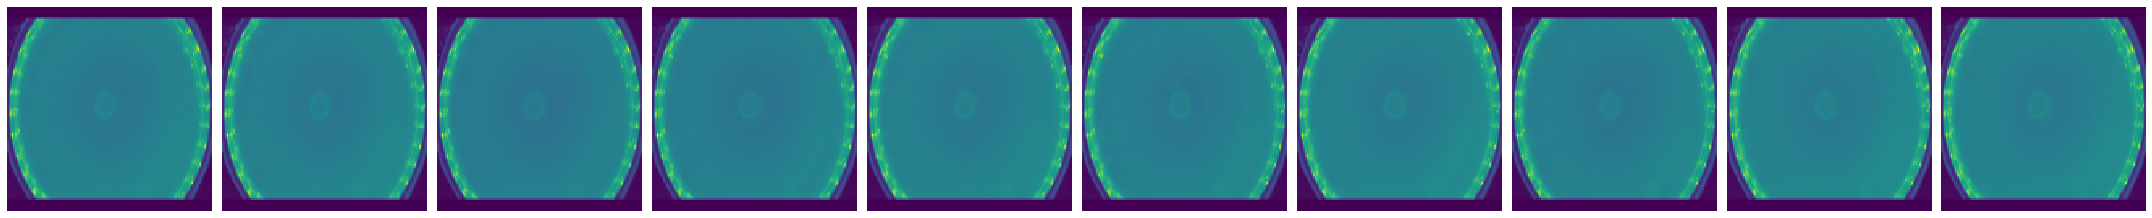

In [7]:
# look at some images
def plotImages(images_arr):
    fig, axes =  plt.subplots(1, 10, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.squeeze(img)) # added squeeze to make it work
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(train_data)

## Reshape the data

In [8]:
print(train_data.shape[2])

# Reshape 
img_width  = train_data.shape[1]
img_height = train_data.shape[2]
num_channels = 1
x_train = train_data.reshape(train_data.shape[0], img_height, img_width, num_channels)

input_shape = (img_height, img_width, num_channels)
print(input_shape)

128
(128, 128, 1)


## Making the VAE

### Encoder

In [9]:
# changing this will make the model exponentially larger or smaller
latent_dim = 2048

# the model (saved in x)
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(64, 3, padding='same', activation='relu')(input_img)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Dropout(0.2)(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(latent_dim*2, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
#  Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 64)   0           max_pooling2d[0][0]              
____________________________________________________________________________________________

### Decoder

In [10]:
# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2048)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              16785408  
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 64)        3692

### Putting Them Together

In [11]:
# makes the loss function (how close is the decoded image to the original)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

In [12]:
# =================
# VAE 
# =================
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
# vae.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 64)   0           max_pooling2d[0][0]              
________________________________________________________________________________________________

## Train the VAE

In [13]:
vae.fit(x_train, None, epochs = 30, batch_size = 32, validation_split = 0.2)

Train on 660 samples, validate on 165 samples
Epoch 1/30
660/660 [==============================] - ETA: 0s - loss: 0.5852

C:\Users\mattp\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


660/660 [==============================] - 69s 104ms/sample - loss: 0.5852 - val_loss: 0.5188
Epoch 2/30
660/660 [==============================] - 64s 97ms/sample - loss: 0.5066 - val_loss: 0.5094
Epoch 3/30
660/660 [==============================] - 66s 100ms/sample - loss: 0.4868 - val_loss: 0.4970
Epoch 4/30
660/660 [==============================] - 63s 96ms/sample - loss: 0.4812 - val_loss: 0.4945
Epoch 5/30
660/660 [==============================] - 65s 98ms/sample - loss: 0.4771 - val_loss: 0.4949
Epoch 6/30
660/660 [==============================] - 63s 95ms/sample - loss: 0.4750 - val_loss: 0.4934
Epoch 7/30
660/660 [==============================] - 62s 95ms/sample - loss: 0.4736 - val_loss: 0.4931
Epoch 8/30
660/660 [==============================] - 65s 98ms/sample - loss: 0.4725 - val_loss: 0.4931
Epoch 9/30
660/660 [==============================] - 64s 98ms/sample - loss: 0.4721 - val_loss: 0.4888
Epoch 10/30
660/660 [==============================] - 65s 98ms/sample - 

## Save It

In [14]:
os.chdir("..")
os.getcwd()

'C:\\Users\\mattp\\Documents\\CoEmergenceLab\\WorldModel-selfmade'

In [18]:
from tensorflow.keras.models import save_model

In [20]:
vae.save_weights('/models/vae')